In [0]:
from fastai.tabular import * 
from fastai.imports import *
from sklearn.utils import shuffle

In [5]:
!gdown https://drive.google.com/uc?id=1euHtxSIItPwAQRtXGsVj3zksTpQ6IvxW

Downloading...
From: https://drive.google.com/uc?id=1euHtxSIItPwAQRtXGsVj3zksTpQ6IvxW
To: /content/titanic.zip
100% 34.8k/34.8k [00:00<00:00, 48.5MB/s]


In [6]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: train.csv               
  inflating: test.csv                
  inflating: gender_submission.csv   


In [0]:
df_train=pd.read_csv("./train.csv")

In [11]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [15]:
df_test=pd.read_csv("./test.csv")
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
for df in [df_train, df_test]:
    df['Alone'] = df['SibSp'] + df['Parch'] == 0
    df['Relatives'] = df['SibSp'] + df['Parch']

In [17]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Alone,Relatives
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,True,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,0


In [0]:
valid_idx=np.random.randint(len(df_train), size=150)

In [0]:
valid_idx

array([689,  11, 277,  79, ..., 144, 451, 172, 745])

In [0]:
def convertToCategorical(df):
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            df[col_name]= df[col_name].astype('category')

In [0]:
convertToCategorical(df_train)
convertToCategorical(df_test)

In [0]:
df_test.Fare=df_test.Fare.fillna(0)

In [0]:
path="./"
dep_var = 'Survived'

In [0]:
cat_names = ['Pclass', 'Sex', 'Embarked', 'Cabin', 'Ticket', 'Alone'] 
cont_names = ['Age', 'Fare', 'SibSp', 'Parch', 'Relatives' ]
procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(df_test, cat_names=cat_names, cont_names=cont_names, procs=procs)


In [0]:
data = (TabularList.from_df(df_train, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(len(df_train)-175,len(df_train)))
                           .label_from_df(cols=dep_var)
                           .add_test(test, label=0)
                           .databunch())

In [30]:
data.train_ds.cat_names

['Pclass', 'Sex', 'Embarked', 'Cabin', 'Ticket', 'Alone', 'Age_na']

In [31]:
data.train_ds.cont_names

['Age', 'Fare', 'SibSp', 'Parch', 'Relatives']

In [0]:
learn = tabular_learner(data, layers=[50, 30], ps=[0.3, 0.3], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


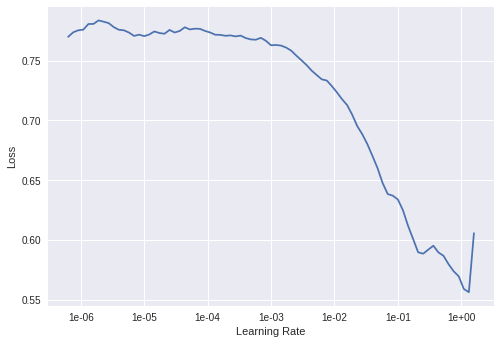

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.600192,0.400594,0.834286,00:00
1,0.468490,0.742540,0.811429,00:00
2,0.340011,0.540956,0.828571,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


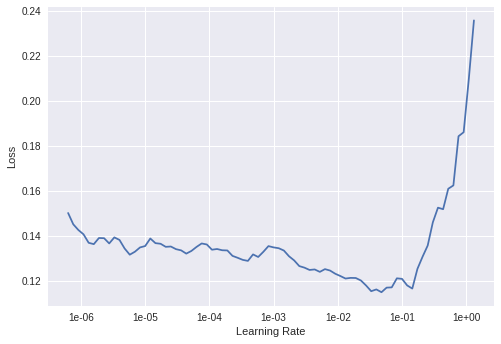

In [37]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save("stage-1")

In [41]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.122352,0.507416,0.828571,00:00
1,0.120363,0.497141,0.822857,00:00
2,0.109202,0.535840,0.817143,00:00
3,0.097442,0.575749,0.817143,00:00
4,0.087268,0.600251,0.817143,00:00
5,0.075455,0.588812,0.817143,00:00
6,0.066408,0.600935,0.817143,00:00
7,0.057511,0.601606,0.817143,00:00
8,0.053041,0.608065,0.817143,00:00
9,0.049723,0.609444,0.817143,00:00


In [42]:
learn.load("stage-1")

learn.validate()

[0.5409565, tensor(0.8286)]

In [0]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [44]:
labels

tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,

In [0]:
res_df = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': labels})
res_df.to_csv('titanic_submission.csv', index=False)